In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Loading datasets
Note that the seperator of these `csv` files are `\t` instead of `,` used in common.

In [2]:
user_dtype = dict(
    age='category',
    gender='category',
    country='category',
    province='category',
    city='category',
    city_level='category',
    device_name='category'
)

user_file  = '../datasets/raw/traindata/user_features_data.csv'
df = pd.read_csv(user_file, sep='\t', index_col='user_id', dtype=user_dtype)

/home/wupj/miniconda3/envs/pytorch17/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## View & Quality
### view
Head view of *user* dataset, which entirely consists of discrete numbers. There are `5910800` users' record in the dataset.

The *user* dataset consists entirely of numbers, it's good.

In [3]:
df.head()

,age,gender,country,province,city,city_level,device_name
user_id,,,,,,,
1757005,3,1,0,9,6,3,327
17938,0,0,0,4,22,3,327
4263520,1,0,0,19,1,5,327
1411600,3,0,0,5,138,1,327
3992242,2,0,0,0,142,0,327


In [4]:
df.describe()

,age,gender,country,province,city,city_level,device_name
count,5910800,5910800,5910800,5910800,5910800,5910800,5910800
unique,8,4,3,33,339,8,1826
top,0,0,0,0,0,0,0
freq,1517588,4291944,5905701,630065,129843,1376384,161778


### Quality
- [x] No duplicte record.
- [x] No `nan` record.

In [5]:
# check duplicte
print(f'duplicate num: {df.index.nunique() - df.shape[0]}')
# check nan
print('nan numbers:')
pd.DataFrame(df.isnull().sum()).T

duplicate num: 0
nan numbers:


,age,gender,country,province,city,city_level,device_name
0,0,0,0,0,0,0,0


## Statistics
* mean
* variance
* information entropy

Based on the following analysis (mostly according to information entropy), we select `age`, `gender`, `province` (weak suggested), `city_level`, `device_name` (weak suggested), as user's features.

In [6]:
def info_entropy(count):
    n = count.sum()
    prob = count.values / n
    return np.sum(prob * -np.log(prob))

In [7]:
stats = dict(mean=[], std=[], entropy=[])
for col in df.columns:
    count = df[col].value_counts()
    stats['mean'].append(count.mean())
    stats['std'].append(count.std())
    stats['entropy'].append(info_entropy(count))
pd.DataFrame(stats, index=df.columns).T

,age,gender,country,province,city,city_level,device_name
mean,738850.000000,1.477700e+06,1.970267e+06,179115.151515,17435.988201,738850.000000,3237.020811
std,574696.049121,2.009354e+06,3.408187e+06,141474.866236,19656.264777,508477.443767,11621.459303
entropy,1.730780,6.346577e-01,7.048076e-03,3.211624,5.391849,1.796097,5.271148


### Device name
According to the analysis results, the devices with counts below **3000** (or device label greater than **250**) should be integrated into one label.

number mean: 3237.0208105147863
number std: 11621.459303297364
info entropy: 5.271148343003711


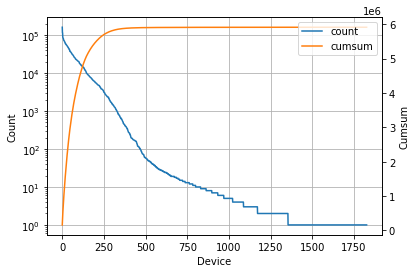

In [8]:
count = df.device_name.value_counts()
print(f'number mean: {count.mean()}')
print(f'number std: {count.std()}')
print(f'info entropy: {info_entropy(count)}')
fig, ax1 = plt.subplots(1,1)
ax2 = ax1.twinx()
ax1.grid()
ax1.plot(count.values, c='C0', label='count')
ax2.plot(count.cumsum().values, c='C1', label='cumsum')
ax1.set_yscale('log')
ax1.set_xlabel('Device')
ax1.set_ylabel('Count')
ax2.set_ylabel('Cumsum')
fig.legend(loc=1, bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
fig.show()

Since there is a significant unbalance in the number of devices, we should keep first $k$ devices and integrate last devices into one label. We discuss $k$ by the infomation entropy of device feature.

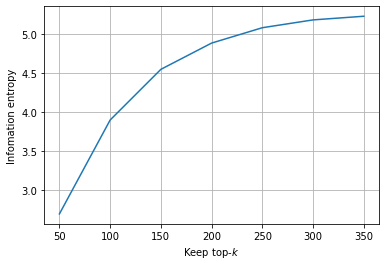

In [9]:
keeps = np.arange(50, 400, 50)
entropy = list()
for k in keeps:
    top_k = df.device_name.value_counts().iloc[:k]
    top_k = top_k.append(pd.Series(df.shape[0] - top_k.sum(), index=[k]))
    entropy.append(info_entropy(top_k))
fig, ax = plt.subplots(1,1)
ax.grid()
ax.plot(keeps, entropy)
ax.set_xlabel('Keep top-$k$')
ax.set_ylabel('Infomation entropy')
fig.show()